## S 검증용 데이터를 활용한 S 함수 검증

In [13]:
import os
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from scipy.io import loadmat

In [3]:
s_test_path = "/data/datasets/hyundai/20200812/s_test_data.mat"
s_test_mat = loadmat(s_test_path)

In [6]:
d = s_test_mat['d']
y = s_test_mat['y']
s_filter = s_test_mat['path_01']

y.shape, d.shape, s_filter.shape

((40000, 8), (40000, 8), (128, 8, 8))

## Pytorch 로 작성한 코드로 검증

In [7]:
y = torch.Tensor(y)
d = torch.Tensor(d)
s_filter = torch.Tensor(s_filter)

In [9]:
def conv_s(y, s_filter):
    # defined as a function
    ## New Conv S => Validated
    Ls, K, M = s_filter.shape
    Tn = y.shape[0]
    y_buffer = torch.zeros((Ls, K))
    y_p = torch.zeros(y.size())
    #e = torch.zeros(y.size())

    for n in range(Tn):
        for k in range(K):
            for m in range(M):
                #print(torch.matmul(y_buffer[:, k].unsqueeze(1).transpose(0,1), s_filter[:, k, m].unsqueeze(1)).shape)
                #y_p[n, m] += torch.mm(y_buffer[:, k].unsqueeze(1).transpose(0,1), s_filter[:, k, m].unsqueeze(1))[0,0]
                y_p[n,m] += torch.dot(y_buffer[:, k], s_filter[:, k, m])

        #e[n, :] = d[n, :] - y_p[n, :]
        y_buffer[1:, :] = y_buffer[:-1, :].clone()
        y_buffer[0, :] = y[n , :]
    return y_p

In [12]:
y_p[:10]

tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 2.0429e-04,  2.6497e-05, -1.7449e-04,  8.9558e-04,  5.9309e-04,
          4.9128e-04,  9.6112e-04,  1.4822e-03],
        [-2.1341e-04, -2.5026e-04, -5.7211e-04,  1.0070e-03,  3.8541e-04,
          5.9100e-04,  1.3107e-03,  1.7248e-03],
        [-1.0255e-03, -1.1081e-04, -7.6510e-04,  6.2931e-04, -2.5832e-04,
          2.7735e-04,  1.0458e-03,  9.2519e-04],
        [-1.8313e-03, -5.7087e-04, -8.7212e-04,  2.0420e-04, -7.4862e-04,
         -8.6783e-05,  1.6333e-04, -1.0128e-03],
        [-2.0280e-03, -1.1575e-03, -7.6286e-04,  1.7695e-04, -1.4615e-03,
         -8.0086e-05, -2.1842e-04, -2.8270e-03],
        [-1.8212e-03, -7.3901e-04, -8.3430e-05,  6.7992e-04, -9.3099e-04,
          7.4767e-04,  4.9389e-04, -1.9154e-03],
        [-2.1486e-03,  9.2706e-04,  1.3413e-03,  3.5788e-03,  6.7416e-04,
          2.5204e-03,  2.6786e-03,  8.5104e-04],
        [-5.0368

In [8]:
e = e.numpy()
y_p = y_p.numpy()
e.shape, y_p.shape

((40000, 8), (40000, 8))

In [9]:
y_prime = y_prime.numpy()
y_prime.shape

(40000, 8)

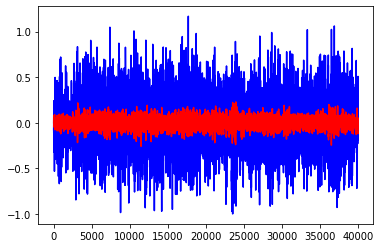

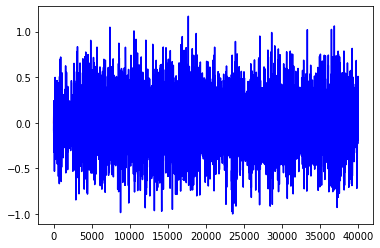

In [10]:
plt.plot(y_prime[:,0], color="blue")
plt.plot(y_p[:,-1], color="red")
plt.show()
plt.plot(y_p[:,-1], color="red")
plt.plot(y_prime[:,0], color="blue")
plt.show()

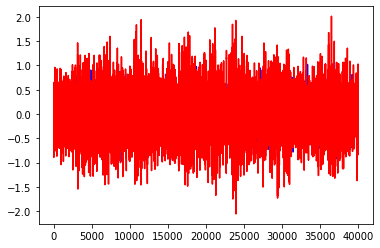

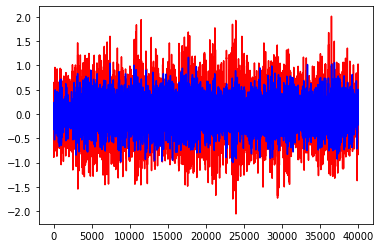

In [11]:
plt.plot(y_prime[:,0], color="blue")
plt.plot(e[:,0], color="red")
plt.show()
plt.plot(e[:,0], color="red")
plt.plot(y_prime[:,0], color="blue")
plt.show()

In [12]:
y_p[1]

array([-0.0036777 , -0.01204786, -0.013684  , -0.01360494,  0.01214635,
        0.01521921,  0.01700906,  0.02382452], dtype=float32)

In [4]:
M, K = 8, 8
Ls = 128
def Shift(y_buffer, k_idx, value):
    y_buffer[1:, k_idx] = y_buffer[:-1, k_idx]
    y_buffer[0, k_idx] = value
    return y_buffer

def Conv_S(signal, S_filter, device='cpu'):
    #Process S filter to waveform data
    #the shape of signal should be (batch, time, 8)
    batch_size = signal.size(0)
    time_len = signal.size(1)
    y_pred = torch.zeros((batch_size, time_len, M), device=device)
    #S_filter = torch.Tensor(S_data).to(device) #(Ls, K, M)
    Y_buffer = torch.zeros((Ls, K), device=device)
    for batch in range(batch_size):
        for n in range(time_len):
            for k in range(K):
                for m in range(M):
                    y_pred[batch, n, m] += torch.dot(Y_buffer[:, k], S_filter[:, k, m])
                    Y_buffer = Shift(Y_buffer, k, signal[batch, n, k])
        
    return y_pred

In [5]:
y_torch = torch.Tensor(y).unsqueeze(0)
s_filter= torch.Tensor(s_filter)
y_torch.shape, s_filter.shape

(torch.Size([1, 40000, 8]), torch.Size([128, 8, 8]))

In [6]:
y_pred = Conv_S(y_torch, s_filter)

In [7]:
y_pred = y_pred.squeeze(0).numpy()

In [8]:
y_pred.shape

(40000, 8)

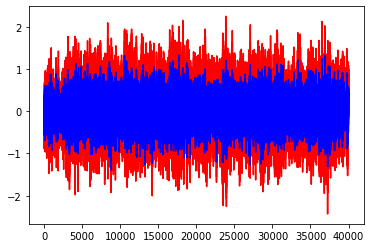

In [11]:
plt.plot(y - y_pred, color="red")
plt.plot(y_prime, color="blue")
plt.show()

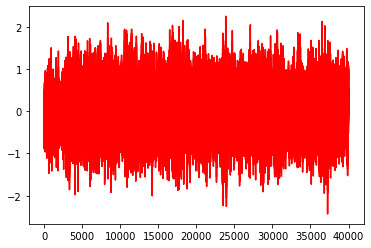

In [12]:
plt.plot(y_prime, color="blue")
plt.plot(y - y_pred, color="red")
plt.show()